# Vendée Globe 2020-2021
#### Project goals are to load and analyse data from the Vendée Globe 2020-2021.




In [1]:
import bs4
import requests
from bs4 import BeautifulSoup
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import os
import json
import warnings
import re
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as ply
from sklearn.linear_model import LinearRegression
from IPython.display import IFrame

InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

## Data Loading
The objective it to retrieve three clean tables:

-_Raw Data_ containing all the information regarding the participants during the race (the information contained in the
Excel files available at https://www.vendeeglobe.org/fr/classement).

-_Classement_ the final ranking of all participants (also available at https://www.vendeeglobe.org/fr/classement).

-_Boat specs_ the information regarding the boats used during the race.

### The _Raw Data_ download  is split into two steps:
1) Extract the list of usable excel files from the drop down
selection box available on the website, use the list ot download all the files to the
_data_ repository

2)Convert all the excel files to dataframes and concatenate them together


In [2]:
## code to all the files to the data repository
##This code is commented out since once run it does not need to be reproduced

# r = requests.get('https://www.vendeeglobe.org/fr/classement')
# r.status_code
# soup = BeautifulSoup(r.content)
# options = soup.find_all('select')
#
# for a in options[0] :
#     if type(a)!=bs4.element.Tag: continue
#     file_name = a['value']
#     path = f'https://www.vendeeglobe.org/download-race-data/vendeeglobe_{file_name}.xlsx'
#     resp = requests.get(path)
#     output = open(f'data/{file_name}.xlsx', 'wb')
#     output.write(resp.content);
#     output.close();
#     print(a['value'])


In [3]:
## code to convert all the excel files to dataframes and concatenate them together
columns=['Date','Rank','Nat/Sail','Skipper/Crew','Hour FR','Latitude','Longitude','Heading_30min','Speed_30min','VMG_30min','Distance_30min','Heading_lrt','Speed_lrt','VMG_lrt','Distance_lrt','Heading_24h','Speed_24h','VMG_24h','Distance_24h','DTF','DTL']
directory = r'/Users/oliviermaxwell/PycharmProjects/TelecomParis/Kit_data/Kit_data_TP/Final_Project/data'
data_list = []
i=0
scalar = 20 #modifies print size
print(f"Starting data Import")
for filename in os.listdir(directory):
    if filename.endswith(".xlsx") and not filename.startswith('~') and not filename.startswith('vendee'):
        undone = 704//scalar  - i//scalar # used for loading bar
        proc = (100 * i) // (704 - 1) # used for loading bar
        print(f"Progress of Import: [{('#' * (i//scalar)) + ('_' * (undone))}] ({proc+1}%)", end='\r')# print loading bar
        df = pd.read_excel(os.path.join(directory, filename),skiprows=4,names=columns,skipfooter=4)
        df['Date'] = filename.replace(".xlsx","")
        data_list.append(df)
        i+=1
    else:
        continue
print(f"\nData Imported successfully!")
raw_data = pd.concat(data_list)
raw_data.head()
#raw_data.to_pickle('raw_data.pickle') # save file to pickle as to not have to re-extract all the information at each run


Starting data Import
Progress of Import: [###################################] (100%)
Data Imported successfully!


,Date,Rank,Nat/Sail,Skipper/Crew,Hour FR,Latitude,Longitude,Heading_30min,Speed_30min,VMG_30min,...,Heading_lrt,Speed_lrt,VMG_lrt,Distance_lrt,Heading_24h,Speed_24h,VMG_24h,Distance_24h,DTF,DTL
0,20201127_140000,1,\nFRA 79,Charlie Dalin\nAPIVIA,14:30 FR\n,41°31.42'S,09°11.14'W,68°,19.5 kts,14.6 kts,...,76°,21.3 kts,17.9 kts,63.9 nm,131°,11.2 kts,10.9 kts,269.9 nm,18580.0 nm,0.0 nm
1,20201127_140000,2,\nFRA 59,Thomas Ruyant\nLinkedOut,14:30 FR\n,38°58.44'S,14°54.88'W,181°,13.5 kts,5.5 kts,...,182°,12.8 kts,5.2 kts,38.3 nm,176°,5.9 kts,3.2 kts,142.6 nm,18880.8 nm,300.9 nm
2,20201127_140000,3,\nFRA 01,Jean Le Cam\nYes we Cam !,14:30 FR\n,36°17.48'S,14°48.81'W,110°,17.1 kts,16.9 kts,...,119°,16.5 kts,16.5 kts,49.4 nm,150°,11.2 kts,10.1 kts,269.8 nm,18950.1 nm,370.2 nm
3,20201127_140000,4,\nFRA 17,Yannick Bestaven\nMaître Coq IV,14:30 FR\n,38°01.60'S,18°23.24'W,105°,16.1 kts,15.8 kts,...,112°,17.5 kts,17.4 kts,52.5 nm,131°,13.5 kts,13.3 kts,323.0 nm,19052.5 nm,472.5 nm
4,20201127_140000,5,\nFRA 85,Kevin Escoffier\nPRB,14:30 FR\n,37°55.75'S,18°38.56'W,107°,17.1 kts,16.9 kts,...,114°,17.2 kts,17.2 kts,51.7 nm,127°,12.6 kts,12.6 kts,303.4 nm,19065.9 nm,486.0 nm


### Clean Raw data

The data collected contains multiple mistakes (ex when people finish the race the Excel is split into two tables)
this step cleans the file

In [4]:
raw_data = pd.read_pickle('raw_data.pickle') #load data
clean_data = raw_data[raw_data['Latitude'] != 'Latitude\nLatitude'] # remove header from second table
clean_data = clean_data[clean_data['Rank'] != 'RET'] # removes retired
clean_data = clean_data[~clean_data['Rank'].str.contains('ARV', na=True)] # remove values from second table
clean_data = clean_data[~clean_data['Rank'].str.contains('Rang\nRank', na=True)] # remove values from second table
clean_data = clean_data[clean_data['Rank'] != ('NL')] # remove values from second table

#this next step is important to create clear values for joining tables together we will select sail number
clean_data[['Nat', 'Sail']] = clean_data['Nat/Sail'].str.split(' ', 1, expand=True)
clean_data['Nat']=clean_data['Nat'].str.replace("\n","")
clean_data['Sail'] = clean_data['Sail'].str.lstrip('0')
clean_data.head()
print (f"The data conatains {clean_data.isna().sum().sum()} NaN values")


,Date,Rank,Nat/Sail,Skipper/Crew,Hour FR,Latitude,Longitude,Heading_30min,Speed_30min,VMG_30min,...,VMG_lrt,Distance_lrt,Heading_24h,Speed_24h,VMG_24h,Distance_24h,DTF,DTL,Nat,Sail
0,20201127_140000,1,\nFRA 79,Charlie Dalin\nAPIVIA,14:30 FR\n,41°31.42'S,09°11.14'W,68°,19.5 kts,14.6 kts,...,17.9 kts,63.9 nm,131°,11.2 kts,10.9 kts,269.9 nm,18580.0 nm,0.0 nm,FRA,79
1,20201127_140000,2,\nFRA 59,Thomas Ruyant\nLinkedOut,14:30 FR\n,38°58.44'S,14°54.88'W,181°,13.5 kts,5.5 kts,...,5.2 kts,38.3 nm,176°,5.9 kts,3.2 kts,142.6 nm,18880.8 nm,300.9 nm,FRA,59
2,20201127_140000,3,\nFRA 01,Jean Le Cam\nYes we Cam !,14:30 FR\n,36°17.48'S,14°48.81'W,110°,17.1 kts,16.9 kts,...,16.5 kts,49.4 nm,150°,11.2 kts,10.1 kts,269.8 nm,18950.1 nm,370.2 nm,FRA,1
3,20201127_140000,4,\nFRA 17,Yannick Bestaven\nMaître Coq IV,14:30 FR\n,38°01.60'S,18°23.24'W,105°,16.1 kts,15.8 kts,...,17.4 kts,52.5 nm,131°,13.5 kts,13.3 kts,323.0 nm,19052.5 nm,472.5 nm,FRA,17
4,20201127_140000,5,\nFRA 85,Kevin Escoffier\nPRB,14:30 FR\n,37°55.75'S,18°38.56'W,107°,17.1 kts,16.9 kts,...,17.2 kts,51.7 nm,127°,12.6 kts,12.6 kts,303.4 nm,19065.9 nm,486.0 nm,FRA,85


The data conatains 0 NaN values


### Get boat spec

This step will parse all the data contained in https://www.vendeeglobe.org/fr/glossaire to create a clear and concise table.
We will convert the html into json and create a dataframe from the json.

In [5]:
r = requests.get('https://www.vendeeglobe.org/fr/glossaire')
soup = BeautifulSoup(r.content)
names = soup.find_all('h3', {'class': "boats-list__boat-name"})# find all boat names
specs = soup.find_all('ul', {'class': "boats-list__popup-specs-list"})# find specs related to boats
spec_list = []

for idx, val in enumerate(names): #enumare throught results
    name = val.text
    spec = specs[idx].text # het html tags related to boat specs
    if idx == 28 : spec = spec.replace("/","\n") # a special issue regarding boat 28 where the symbol '/' is used
                                                # differently throughout the web page
    spec = spec.replace(","," ")#convert to json
    spec = spec.replace("\n","\",\"")#convert to json
    spec = "{"+spec.replace(" : ","\":\"")[2:-2]+"}"#convert to json
    json_spec = json.loads(spec)
    pd_spec = pd.DataFrame(list(json_spec.items())).transpose()
    pd_spec = pd_spec.rename(columns=pd_spec.iloc[0]).drop(pd_spec.index[0])
    pd_spec['Name'] = name
    spec_list.append(pd_spec)
boat_spec = pd.concat(spec_list,ignore_index=True)
#data cleaning some values are missing and need to be added manualy
boat_spec.loc[(boat_spec["Name"]=='MEDALLIA'),"Numéro de voile"]=777
boat_spec.loc[(boat_spec["Name"]=='LinkedOut'),"Numéro de voile"]=59
boat_spec.loc[(boat_spec["Name"]=='SEAEXPLORER - YACHT CLUB DE MONACO'),"Numéro de voile"]=10
# extract the sail number this info will be used to join tables later
boat_spec['Numéro de voile'] = boat_spec['Numéro de voile'].apply(lambda x :re.sub("[^0-9]", "",str(x)))
boat_spec['Numéro de voile'] = boat_spec['Numéro de voile'].str.lstrip('0')
boat_spec['Sail'] = boat_spec['Numéro de voile']
boat_spec.head()


,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,Name,Assemblage,Sail
0,56,No Way Back Vento di Sardegna,VPLP/Verdier,Persico Marine,01 Août 2015,18 28 m,5 85 m,4 50 m,7 t,foils,29 m,monotype,320 m2,570 m2,NEWREST - ART & FENÊTRES,NaN,56
1,49,Gitana Eighty Synerciel Newrest-Matmut,Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,18 28m,5 80m,4 50m,9t,2,28m,acier forgé,280 m2,560 m2,PURE - Best Western®,NaN,49
2,72,Famille Mary-Etamine du Lys Initiatives Coeur...,Marc Lombard,MAG France,01 Mars 1998,18 28m,5 54m,4 50m,9t,2,29 m,acier,260 m2,580 m2,TSE - 4MYPLANET,NaN,72
3,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,18 28 m,5 80 m,4 50 m,8 t,foils,29 m,acier mécano soudé,310 m2,550 m2,Maître CoQ IV,NaN,17
4,8,NaN,VPLP,CDK Technologies,18 Août 2018,18 28 m,5 85 m,4 50 m,8t,foils,29 m,acier,320 m2,600 m2,CHARAL,NaN,8


### Get final boat ranks
Extract the final excel and save it to a table to retrieve the final status of all boats

In [6]:
# due to the excel format some columns must be removed these columns are named REMOVE(X) and will be dropped from the dataframe
columns=['REMOVE0','Rang','Natio / Voile','Skipper / Bateau','REMOVE1','REMOVE2','REMOVE3','Date d\'arrivée','Temps de course','REMOVE9','REMOVE8','REMOVE7','REMOVE4','Écarts-Au premier','REMOVE5','Écarts-Au précédent','Sur l\'ortho (Vitesse)','Sur l\'ortho(Distance)','% Done','Sur le fond (Vitesse)','Sur le fond(Distance)']
len(columns)
df = pd.read_excel('/Users/oliviermaxwell/PycharmProjects/TelecomParis/Kit_data/Kit_data_TP/Final_Project/data/vendeeglobe_20210305_080000.xlsx'
                           ,skiprows=4,names=columns,skipfooter=0)

classement = df[df.columns.drop(list(df.filter(regex='REMOVE')))]
classement = classement.iloc[:33]
classement[['Natio', 'Voile']] = classement['Natio / Voile'].str.split(' ', 1, expand=True)
classement['Natio'] = classement['Natio'].str.split('\n',1,expand=True)[1]
classement['Voile'] = classement['Voile'].str.lstrip('0')
classement['Sail'] = classement['Voile']
classement.loc[(classement['Rang']=='RET'),"Rang"]='99\nRET' # set rank to 99 for participants who retired from the race
classement[['Rang','Status']] = classement['Rang'].str.split('\n',2,expand=True)
classement.head()


21

,Rang,Natio / Voile,Skipper / Bateau,Date d'arrivée,Temps de course,Écarts-Au premier,Écarts-Au précédent,Sur l'ortho (Vitesse),Sur l'ortho(Distance),% Done,Sur le fond (Vitesse),Sur le fond(Distance),Natio,Voile,Sail,Status
0,1,\nFRA 17,Yannick Bestaven\nMaître Coq IV,28/01/2021 04:19:46 FR,80j 03h 44min 46s\n-10h 15min 00s,NaN,NaN,12.6 kts,24365.7 nm,117.3 %,14.8 kts,28583.8 nm,FRA,17,17,ARV
1,2,\nFRA 79,Charlie Dalin\nAPIVIA,27/01/2021 20:35:47 FR,80j 06h 15min 47s\n,02h 31min 01s,02h 31min 01s,12.6 kts,24365.7 nm,119.6 %,15.1 kts,29135.0 nm,FRA,79,79,ARV
2,3,\nFRA 18,Louis Burton\nBureau Vallée 2,28/01/2021 00:45:12 FR,80j 10h 25min 12s\n,06h 40min 26s,04h 09min 25s,12.6 kts,24365.7 nm,117.6 %,14.8 kts,28650.0 nm,FRA,18,18,ARV
3,4,\nFRA 01,Jean Le Cam\nYes we Cam !,28/01/2021 20:19:55 FR,80j 13h 44min 55s\n-16h 15min 00s,10h 00min 09s,03h 19min 43s,12.5 kts,24365.7 nm,112.9 %,14.1 kts,27501.5 nm,FRA,1,1,ARV
4,5,\nMON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,28/01/2021 11:19:45 FR,80j 14h 59min 45s\n-06h 00min 00s,11h 14min 59s,01h 14min 50s,12.6 kts,24365.7 nm,116.8 %,14.7 kts,28448.5 nm,MON,10,10,ARV


## Analysis
The analysis is split up into two main parts _Quantitative analysis_ and _Visual analysis_:

### Quantitative analysis

We will first look into the general stats of the race, the average speed, distance and rank of participants,
displaying this information as a table with average speed decreasing.

In [7]:
clean_data_shortened = clean_data[["Skipper/Crew","Speed_lrt","Sail"]]
clean_data_shortened["Speed_lrt"] = clean_data_shortened["Speed_lrt"].str.replace('kts','').astype(float)
classement_shortened = classement[['Rang','Sail','Sur le fond(Distance)']]
classement_shortened['Rang'] = classement_shortened['Rang']

average_speed = pd.pivot_table(clean_data_shortened,index=["Sail","Skipper/Crew"])
average_speed_wth_rank = pd.merge(average_speed,classement_shortened,on=["Sail"])
average_speed_wth_rank = average_speed_wth_rank.sort_values(by=["Speed_lrt"],ascending=False)

_ = average_speed_wth_rank.set_index("Sail");

display(average_speed_wth_rank)


,Sail,Speed_lrt,Rang,Sur le fond(Distance)
7,18,14.773853,3,28650.0 nm
26,79,14.714747,2,29135.0 nm
19,59,14.705263,6,29175.5 nm
6,17,14.621101,1,28583.8 nm
1,10,14.599543,5,28448.5 nm
13,34,14.552620,8,28489.9 nm
14,4,14.520721,99,NaN
29,85,14.406667,99,NaN
10,27,14.288754,99,NaN
20,6,14.166667,99,NaN


This table gives use preliminary information regarding the race, we can see the average speed of participants who did
not complete the race to be relatively high, this could indicate that going too quickly can cause issues later on in the race
(this topic is not explored further).

The average speed and rank of participants seem closely related (this will be explored in the step) however the distance,
and the rank do not seem related which is conter intuitive for a race, usually the winner has taken the shortest route,
this topic will be explored further with the analysis the impact foils have on a boat.

To explore the relation between average speed and final rank a linear regression will be performed.

LinearRegression()

Text(0.5, 1.0, 'Linear Regression of rank on average speed ')

Text(0.5, 0, 'Average speed (knots)')

Text(0, 0.5, 'Final Rank')

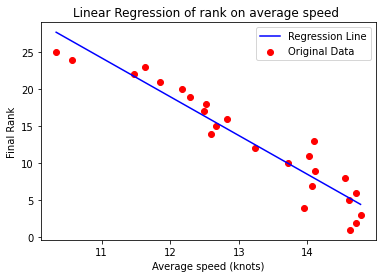

The R² value for this linear regression is 0.90287


In [8]:
average_speed_wth_rank_finishers = average_speed_wth_rank.loc[average_speed_wth_rank['Rang']!='99']
X = average_speed_wth_rank_finishers["Speed_lrt"].astype(float)
Y = average_speed_wth_rank_finishers["Rang"].astype(int)
X = X.to_numpy().reshape(25,1)
Y = Y.to_numpy().reshape(25,1)


model = LinearRegression(); #original code from https://realpython.com/linear-regression-in-python/
model.fit(X, Y);
r_sq = model.score(X, Y);
intercept = model.intercept_;
sloap = model.coef_;

pred_y = X*sloap +intercept

orig = plt.scatter(X, Y,color='r',label="Original Data");
pred = plt.plot(X,pred_y,color='b',label="Regression Line");
plt.title("Linear Regression of rank on average speed ");
plt.xlabel("Average speed (knots)");
plt.ylabel("Final Rank");
plt.legend();
plt.show();
print(f"The R\u00b2 value for this linear regression is {r_sq:.5f}")

The previous graph shows a clear correlation between the average speed and final rank of the participants, an R<sup>2</sup>
score of 0.90287 is considered to statistically relative in most scientific fields<sup>[1]</sup> this means a croreelction exists between the two features.

We will now look at the impact foils have on a participant.


<font size="1"><sup>[1]</sup> Lewis-Beck, Michael S., and Andrew Skalaban. "The R-squared: Some straight talk." Political Analysis 2 (1990): 153-171.</font>

In [9]:
df_foils = clean_data[["Skipper/Crew","Sail","Speed_lrt","Distance_lrt","VMG_lrt"]]
df_foils["Speed_lrt"] = df_foils["Speed_lrt"].str.replace('kts','').astype(float)
df_foils["VMG_lrt"] =df_foils["VMG_lrt"].str.replace('kts','').astype(float)
df_foils["Distance_lrt"] = df_foils["Distance_lrt"].str.replace('nm','').astype(float)
df_foils["Of_course_index"] = df_foils["Speed_lrt"]-df_foils["VMG_lrt"]
df_foils = pd.pivot_table(df_foils,
                                      index="Sail",
                                      values = ["Speed_lrt","Distance_lrt","Of_course_index"])

df_foils = pd.merge(df_foils,boat_spec[['Sail','Nombre de dérives']],on=["Sail"])
df_foils = pd.merge(df_foils,classement[['Sail','Rang']],on=["Sail"])
df_foils['Rang'] = df_foils['Rang'].astype(float)
def convertFoil(x):
    if x =="foils" or x=="foiler" : return 1
    else : return 0
df_foils["Foils"] = df_foils["Nombre de dérives"].apply(convertFoil)
df_foils = df_foils.loc[df_foils['Sail']!='6']
df_foils = df_foils.drop(["Nombre de dérives","Sail"],axis =1)
df_foils_finisher = df_foils.loc[df_foils["Rang"] !=99.0]

df_foils["finished (%)"] = df_foils['Rang'].apply(lambda x : 0 if (x==99.0) else 100)
Foil_analysis = pd.pivot_table(df_foils,
                               index="Foils")
display("All participants:")
display(Foil_analysis)

display("Only participants who finished:")
Foil_analysis = pd.pivot_table(df_foils_finisher,
                               index="Foils")
display(Foil_analysis)


'All participants:'

,Distance_lrt,Of_course_index,Rang,Speed_lrt,finished (%)
Foils,,,,,
0,54.351898,1.304816,22.071429,12.268235,92.857143
1,65.642067,1.811077,39.388889,13.806365,66.666667


'Only participants who finished:'

,Distance_lrt,Of_course_index,Rang,Speed_lrt
Foils,,,,
0,54.977699,1.283212,16.153846,12.461134
1,60.628290,1.629735,9.583333,13.883240


Looking at the impact foils have on a participant, two main conclusions can be drawn, participant who use foils have a
lower chance of finishing the race, 92% vs 66%. Participants who use foils do not go for the most direct route, this can be seen
with the *Of Course Index* which is the average difference between the participants current course and the ideal race course.

### Visual analysis


The first plot we will show is the evolution of the participants rank during the race.

Evolution of ranks in the race

In [10]:
def formatDate(x):
    x = x.replace("_","")
    x = f"{x[6:8]}/{x[4:6]}/{x[0:4]}({x[8:10]}:{x[10:12]})"
    return x

clean_data_shortened = clean_data[["Skipper/Crew","Rank","Sail",'Date']]
clean_data_shortened['Date'] = clean_data_shortened['Date'].str.replace("_","")
clean_data_shortened["Crew"] = clean_data_shortened["Skipper/Crew"].str.split("\n",1,expand=True)[0]
table = pd.pivot_table(clean_data_shortened,
                      index=["Sail","Crew"],
                      columns='Date',
                      values = 'Rank')

classement_short = classement[["Rang","Sail"]]
table = table.reset_index()
table = pd.merge(table,classement_short,on=["Sail"])
table = table.set_index(["Crew","Rang"])
table = table.drop(columns = ["Sail"])
table = table.transpose()
table.index = list(map(formatDate,table.index))# rename index to make table values nicer


<Figure size 1080x720 with 0 Axes>

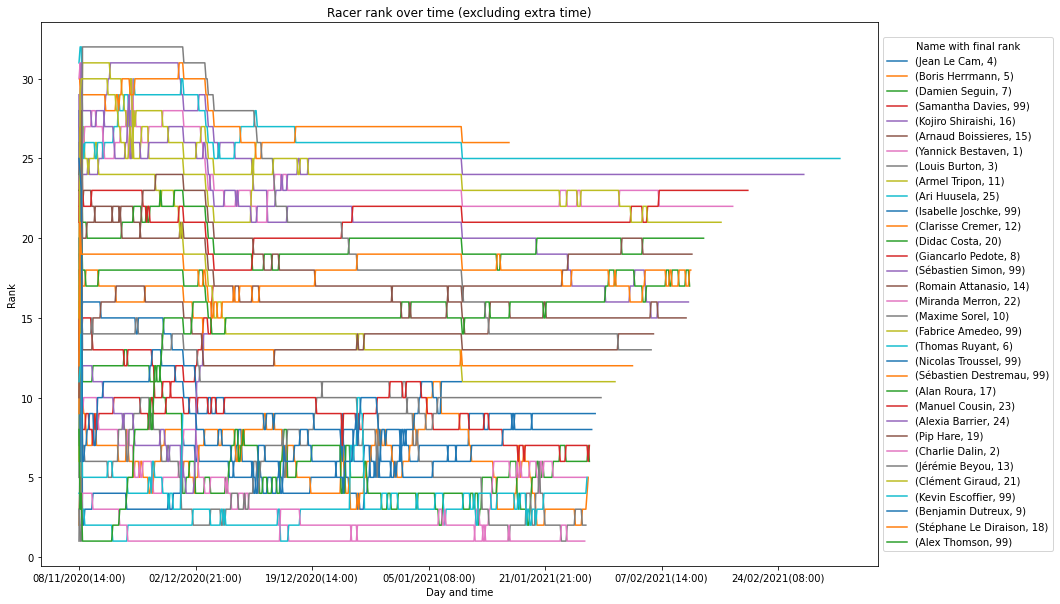

In [11]:
plt.rcParams['figure.figsize'] = [15, 10];
plt.figure();
table.plot();
plt.title("Racer rank over time (excluding extra time)")
plt.legend(title = "Name with final rank",loc='center left', bbox_to_anchor=(1, 0.5));

plt.xlabel("Day and time")
plt.ylabel("Rank")

plt.show();

This graph may seem a bit chaotic at first however shows quite clearly the tense moments of the race, for exemple the
tight finish between Stéphane Le Diraison and Alan Roura.

To conclude we will plot the different trips made by different participants.

In [12]:
# conversion latitude longitude (source : https://en.proft.me/2015/09/20/converting-latitude-and-longitude-decimal-values-p/)
data_graph = clean_data[["Latitude","Longitude","Sail","Date"]]

def dms2dd(deg, min, sec, dir):
    dd = float(deg) + float(min)/60. + float(sec)/(60.*60.);
    if dir == 'S' or dir == 'W':
        dd *= -1
    return dd;

def parse_dms(dms):
    parts = re.split('[^\d\w]+', dms)
    conv = dms2dd(parts[0], parts[1], parts[2], parts[3])
    return (conv);

data_graph["Latitude_str"] = data_graph["Latitude"].astype('string')
data_graph["Longitude_str"] = data_graph["Longitude"].astype('string')

data_graph["Latitude_2"] = data_graph["Latitude"].apply(parse_dms)
data_graph["Longitude_2"] = data_graph["Longitude"].apply(parse_dms)

data_graph = pd.pivot_table(data_graph,
                               index="Sail",
                               columns="Date")



In [13]:
number=6 # modify number to see other participants
fig1 = px.line_geo( data_graph,
                    lat = data_graph["Latitude_2"].iloc[number],
                    lon = data_graph["Longitude_2"].iloc[number],
                    projection='mercator')
#fig1.show()
path_to_plot = "plot.html"
#ply.offline.plot(fig1, filename=path_to_plot)
IFrame(src=path_to_plot, width=500, height=500)

